# Import modules and dependencies

In [29]:
# Import modules
import os
import keras
import librosa
import random
import sklearn
import IPython
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt

# Import dependencies
from matplotlib import pyplot
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras import models

# Download dataset

In [8]:
# Download the dataset
!wget 'http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip'
!unzip mini_speech_commands.zip

!unzip -o mini_speech_commands.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-09-06 08:33:37--  http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.142.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182082353 (174M) [application/zip]
Saving to: 'mini_speech_commands.zip.6'

mini_speech_command 100%[===================>] 173.65M   255MB/s    in 0.7s    

2024-09-06 08:33:38 (255 MB/s) - 'mini_speech_commands.zip.6' saved [182082353/182082353]

Archive:  mini_speech_commands.zip
replace __MACOSX/._mini_speech_commands? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  mini_speech_commands.zip
  inflating: __MACOSX/._mini_speech_commands  
  inflating: __MACOSX/mini_speech_commands/._right  
  inflating: __MACOSX/mini_speech_commands/._go  
  inflating: __MACOSX/mini_speech_commands/._no  
  inflating: __MACOSX/mini_

# Data exploration and visualization 

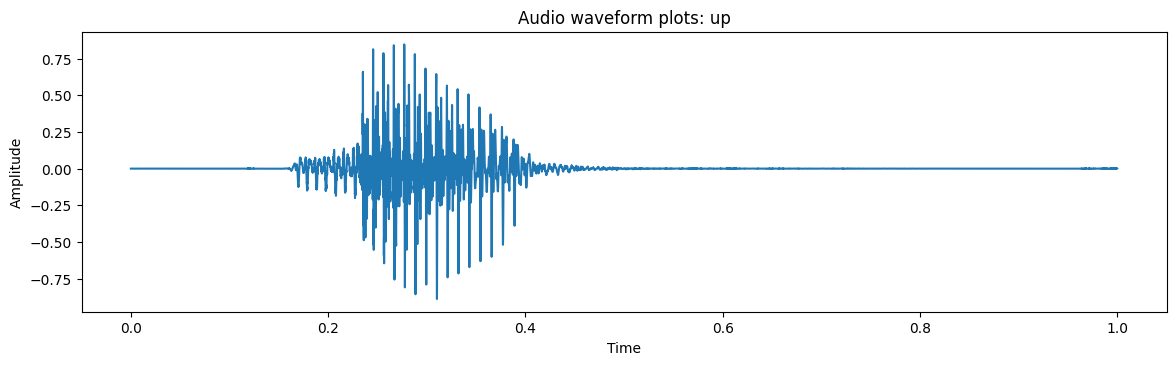

In [12]:
# Load the data
audio_data_path = '/kaggle/working/mini_speech_commands/'
samples, sample_rate = librosa.load(audio_data_path + '/no/94de6a6a_nohash_2.wav', sr=16000)

# Generate waveform
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Audio waveform plots: up')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate / len(samples), sample_rate), samples)

In [13]:
IPython.display.Audio(data=samples, rate=8000)

In [14]:
commands_list = np.array(tf.io.gfile.listdir(str(audio_data_path)))
commands_list = commands_list[commands_list != 'README.md']
print('Commands_list:', commands_list)

Commands_list: ['right' 'yes' 'stop' 'down' 'left' 'no' 'up' 'go']


In [17]:
# Remove unnecessary files
!rm '/kaggle/working/mini_speech_commands/README.md'

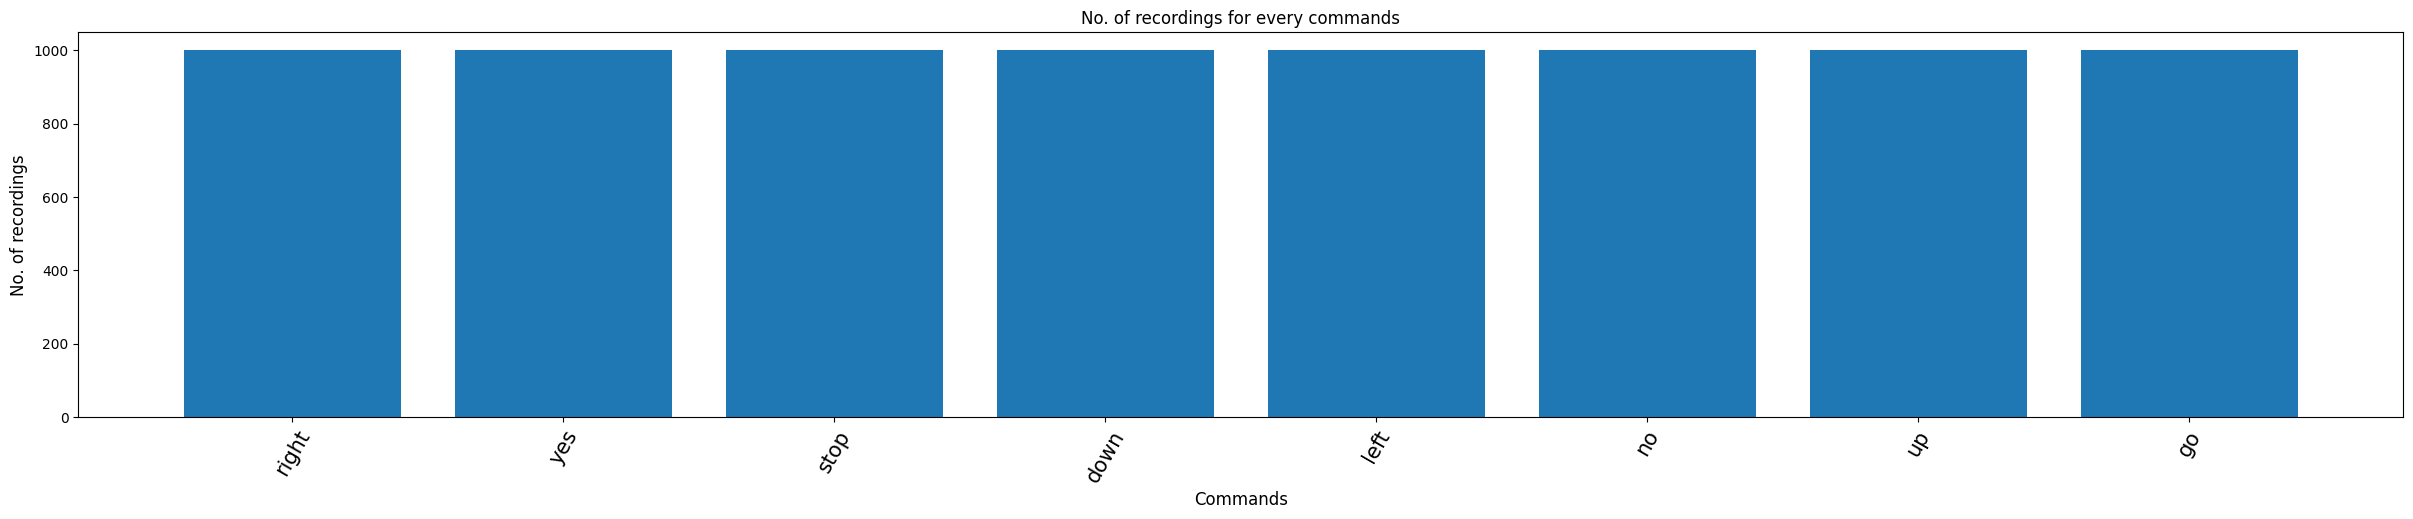

In [19]:
# Generate bar chart
labels = os.listdir(audio_data_path)
no_of_recordings = []

for label in labels:
    waves = [f for f in os.listdir(audio_data_path + '/' + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

plt.figure(figsize=(30, 5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No. of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for every commands')
plt.show()

# Pre-processing

In [24]:
train_audio_path = '/kaggle/working/mini_speech_commands'

all_wave = []
all_label = []

for label in labels:
    print(label)
    waves = [f for f in os.listdir(audio_data_path + '/' + label) if f.endswith('.wav')]
    
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr=16000)
        samples = librosa.resample(y=samples, orig_sr=sample_rate, target_sr=8000)
        
        if(len(samples)==8000):
            all_wave.append(samples)
            all_label.append(label)

right
yes
stop
down
left
no
up
go


In [26]:
# Convert output labels to encoded integers
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

y = to_categorical(y, num_classes=len(labels))
all_wave = np.array(all_wave).reshape(-1, 8000, 1)

# Training

In [35]:
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(all_wave),
    np.array(y),
    stratify=y,
    test_size=0.2,
    random_state=777,
    shuffle=True
)

In [36]:
K.clear_session()

inputs = Input(shape=(8000, 1))

# Conv1D, 1st layer
my_model = Conv1D(8, 13, padding='valid', activation='relu', strides=1)(inputs)
my_model = MaxPooling1D(3)(my_model)
my_model = Dropout(0.3)(my_model)

# Conv1D, 2nd layer
my_model = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(my_model)
my_model = MaxPooling1D(3)(my_model)
my_model = Dropout(0.3)(my_model)

# Conv1D, 3rd layer
my_model = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(inputs)
my_model = MaxPooling1D(3)(my_model)
my_model = Dropout(0.3)(my_model)

# Conv1D, 4th layer
my_model = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(inputs)
my_model = MaxPooling1D(3)(my_model)
my_model = Dropout(0.3)(my_model)

# Flatten layer
my_model = Flatten()(my_model)

# Dense, 1st layer
my_model = Dense(256, activation='relu')(my_model)
my_model = Dropout(0.3)(my_model)

# Dense, 2nd layer
my_model = Dense(128, activation='relu')(my_model)
my_model = Dropout(0.3)(my_model)

outputs = Dense(len(labels), activation='softmax')(my_model)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 7994, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2664, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2664, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 170496)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    43,647,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,681,672 (166.63 MB)

 Trainable params: 43,681,672 (166.63 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Define the loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
# Define callbacks
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    min_delta=0.0001
)

mc = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [39]:
# Perform the training phase
history = model.fit(
    x_tr,
    y_tr,
    epochs=100,
    callbacks=[es, mc],
    batch_size=32,
    validation_data=(x_val, y_val)
)

Epoch 1/100


I0000 00:00:1725612948.153800     469 service.cc:145] XLA service 0x79b7380052f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725612948.153861     469 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/180 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1522 - loss: 2.1436

I0000 00:00:1725612954.512242     469 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1644 - loss: 2.0998
Epoch 1: val_accuracy improved from -inf to 0.24443, saving model to best_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.1645 - loss: 2.0996 - val_accuracy: 0.2444 - val_loss: 1.9946
Epoch 2/100
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2687 - loss: 1.9202
Epoch 2: val_accuracy improved from 0.24443 to 0.33078, saving model to best_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2690 - loss: 1.9196 - val_accuracy: 0.3308 - val_loss: 1.7956
Epoch 3/100
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3991 - loss: 1.5994
Epoch 3: val_accuracy improved from 0.33078 to 0.39345, saving model to best_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.3993 - loss: 1.5990 - val_accuracy: 0.3935 - val_loss: 1.6520
Epoch 4/100
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5199 - loss: 1.2942
Epoch 4: val_accuracy improved from 0.393

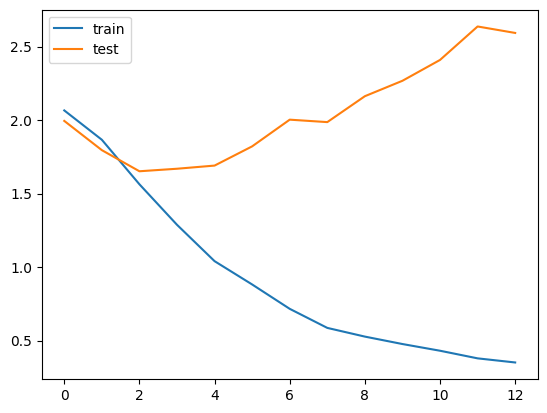

In [40]:
# Plot the loss rates
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Testing and prediction

In [42]:
model = load_model('best_model.keras')

def predict(audio):
    prob = model.predict(audio.reshape(1, 8000, 1))
    index = np.argmax(prob[0])
    return classes[index]

In [43]:
index = random.randint(0, len(x_val) - 1)
samples = x_val[index].ravel()
print("Audio", classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio go
